---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
license: "CC BY"
copyright: 
  holder: Matthew Reda
  year: 2025
citation: true
---

# The Illusion of Significance

> The Cost of p-Values

---
abstract: |
    Statistical models drive millions in spending decisions, yet beneath their precise-looking numbers lurks a dangerous problem. This post examines how the practice of selecting variables based on p-values creates a statistical house of cards; especially in Marketing Mix Modeling (MMM) and budget optimization. I show why common techniques like stepwise regression inevitably produce overconfident models with biased estimates that violate the very statistical principles they claim to uphold. These methodological flaws can result in money flowing to the wrong marketing channels based on **illusory** performance metrics. I demonstrate why Bayesian approaches offer a more honest alternative by naturally tempering overconfidence, incorporating what we already know, and providing intuitive uncertainty measures. Through techniques like spike-and-slab priors (or regularized horseshoe priors) and Bayesian Model Averaging (BMA), analysts can move beyond arbitrary significance thresholds toward probability-based decision-making. While Bayesian methods do require more computational horsepower and thoughtful prior specification, modern software has made them increasingly accessible. Using simulated examples inspired by real-world marketing and economic modeling, I show how Bayesian methods produce more reliable insights that lead to smarter budget allocation decisions.
---

## From Illusion to Insight — TLDR

We've all seen it (perhaps even presented it); the perfectly constructed model with impressive-looking p-values that is used to justify adding millions in budget to a particular marketing channel. But how much can we really trust these insights? Statistical modeling approaches that rely on p-value thresholds (or $\left| \text{t-stat}\right| > 1$) for variable selection create a fundamental problem: the same data that builds the model also validates it, creating a circular logic that **inevitably** results in overconfidence. Methods like stepwise regression don't just produce slightly inaccurate models: they systematically generate **biased coefficients**, **invalid statistical tests**, and **unstable predictions**. When these flawed models drive budget decisions, organizations end up misallocating resources based on what amounts to **statistical mirages** rather than **genuine insights**.

Bayesian statistics offers a more realistic alternative that acknowledges what traditional methods try to hide. **Uncertainty is real!** It should inform our decisions and not be artificially removed through statistical hocus-pocus for a slick deck. By treating parameters as variables with probability distributions and formally incorporating prior knowledge, Bayesian methods can help regularize models; prevent them from making wild claims the data can't support. Techniques like spike-and-slab priors let us evaluate which variables truly matter without arbitrary cutoffs, while Bayesian Model Averaging sensibly hedges bets across multiple plausible models rather than on a single one. Though implementing Bayesian approaches does require more computational power, technical skill, and careful thought about prior assumptions, the payoff is substantial: **more stable estimates**, **intuitive uncertainty measures** that stakeholders can actually understand (seriously what is a confidence interval), and ultimately, budget allocation **insights** based on reality rather than **statistical illusions**.

## Introduction: Modeling for Decision Making

### The Hidden Costs of Misspecification: Why Model Selection Matters

Statistical models, particularly within econometrics and marketing analytics, serve as critical instruments for dissecting complex business phenomena and guiding strategic decisions. Marketing Mix Modeling (MMM) stands as a prime example. The insights derived from MMM are frequently used for two primary purposes: understanding the historical contribution of different marketing levers and, crucially, optimizing future budget allocations to maximize return on investment (ROI). 

MMM's use extends beyond prediction toward causal inference: understanding the "true", incremental impact of altering a specific input, such as increasing social advertising spend, on the outcome variable (i.e. sales). This causal understanding is paramount for effective budget optimization.

However, standard modeling procedures, particularly those involving selection based on statistical significance, prioritize in-sample fit over robustness and causal validity. This focus inadvertently introduces substantial biases and instability. When models that systematically misrepresent causal effects guide budget decisions, organizations face significant resource misallocation that directly impacts profitability. The aggregated and time-series nature of marketing data further compounds these challenges, as weekly or monthly observations limit statistical power while still requiring controls for seasonality, economic trends, and competitive actions

As marketing analytics continues to drive increasingly larger investment decisions, the potential damage from flawed model specifications grows proportionally. This page examines how traditional variable selection approaches might generate misleading insights and offers a more robust Bayesian framework for addressing these methodological pitfalls.

### The P-Value Trap: Why Significance Testing Misleads Model Selection

While p-values remain ubiquitous in statistical analysis, their application in model selection creates systematic distortions. The p-value measures the probability of observing data equally or more extreme than what was collected, assuming the null hypothesis holds true. Yet this metric becomes deeply problematic when used as a selection criterion.

**Critical misconceptions persist:** Statistical significance doesn't equate to practical importance. Large datasets can render trivial effects "significant," while genuinely important relationships may fail arbitrary thresholds. When automated procedures like stepwise regression rely on p-values for variable selection, they introduce cascading failures:

#### The Seven Deadly Sins of P-Value Selection

::: {.callout-note collapse=true}
## The math behind t-stats

In the context of linear regression the test statistic for the i-th coefficient estimate is given as: 

$$
\frac{\hat{\beta_i}}{\frac{\hat{\sigma}}{\sqrt{n\hat{\text{Var}}[X_i]}}\sqrt{VIF_i}}
$$

It's clear from the mathematical description of the test statistic that:

1. Coefficients ($\hat{\beta_i}$) with larger magnitudes — all else being equal — will be more "significant". 
2. Models with lower variance ($\hat{\sigma}$) will lead to all coefficients being more "significant".
3. Larger sample sizes (n) will increase all coefficients t-stat.
4. With increased variance in a predictor ($\hat{\sigma}$) — all else being equal — that predictor will be more "significant".
5. With increased correlation of covariate $X_i$ ($VIF_i$) — all else being equal — that predictor will be less "significant".
   
:::

**1. Systematized Cherry-Picking**  
Stepwise procedures systematically explore variable combinations until finding "significant" patterns. This automated search through analytical choices—different predictors, transformations, and specifications—guarantees finding patterns that appear meaningful but often reflect random noise. Even examining residuals to guide variable addition constitutes this problematic practice.

**2. The Multiplicity Trap**  
Testing numerous variables inflates false discovery rates exponentially. When evaluating 20 potential predictors, the chance of incorrectly declaring at least one significant approaches certainty. Standard software reports unadjusted p-values, hiding the true extent of multiple testing performed during selection.

In [ ]:
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import random_correlation
import statsmodels.api as sm
import pymc as pm
import arviz as az
from tueplots import bundles
from tueplots.constants.color import rgb
from common_regression_issues.utils.plotting import rgb_to_hex

In [ ]:
#| hide
np.random.seed(42)
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

::: {.callout-note collapse=true}
## Helper Functions

In [ ]:
def random_covariance(n_vars):
    """Create a random covariance matrix with a given correlation."""
    
    # Create a random correlation matrix
    A = np.random.randn(n_vars, n_vars)
    cov_matrix = np.dot(A, A.T)

    return cov_matrix

def create_data_no_signal(n_samples, n_vars, correlated=True):
    """Create completely random data with no signal."""
    
    mean = np.zeros(n_vars)
    if correlated:
        cov = random_covariance(n_signal_vars+n_noise_vars)
        var = np.diag(cov)
        # Ensure var of variables is 1
        cov = cov / np.sqrt(var[:, None] * var[None, :])
    else:
        cov = np.eye(n_signal_vars+n_noise_vars)

    X = np.random.multivariate_normal(
        mean=mean, 
        cov=cov, 
        size=n_samples
        )

    y = np.random.randn(n_samples)

    return pd.DataFrame(X), pd.Series(y)



def create_data_with_signal(
    n_samples, 
    n_signal_vars, 
    n_noise_vars, 
    betas = None,
    correlated = True,
    noise_level=1):
    """Create data with a signal in the first n_signal_vars."""
    
    mean = np.zeros(n_signal_vars+n_noise_vars)
    if correlated:
        cov = random_covariance(n_signal_vars+n_noise_vars)
        var = np.diag(cov)
        # Ensure var of variables is 1
        cov = cov / np.sqrt(var[:, None] * var[None, :])
    else:
        cov = np.eye(n_signal_vars+n_noise_vars)

    
    X = np.random.multivariate_normal(
        mean=mean, 
        cov=cov,
        size=n_samples)
    
    if betas is None:
        betas = np.zeros(n_signal_vars + n_noise_vars)
        betas[:n_signal_vars] = np.random.randn(n_signal_vars)
        
    assert len(betas) == n_signal_vars + n_noise_vars, "betas must have the same length as the number of variables"

    # Create a signal in the first n_signal_vars
    y = np.dot(X, betas) + np.random.randn(n_samples) * noise_level * np.var(np.dot(X, betas))

    return pd.DataFrame(X), pd.Series(y), betas

def forward_selection(
    X: pd.DataFrame, y: pd.Series,
    threshold_in=0.05
):
    """Perform forward selection with p-values to find the best subset of features."""
    
    # Initialize variables
    n_features = X.shape[1]
    selected_features = []
    remaining_features = list(X.columns)
    np.random.shuffle(remaining_features) # Shuffle features to simulate repeated runs
    
    # Perform forward selection with p-values
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            features = selected_features + [candidate]
            X_subset = X.loc[:, features]
            model = sm.OLS(y, sm.add_constant(X_subset)).fit()
            p_value = model.pvalues[candidate]
            
            scores_with_candidates.append((p_value, candidate))
        
        # Sort scores and select the best candidate
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if best_new_score < threshold_in:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            break
    return selected_features

def backward_selection(
    X: pd.DataFrame, y: pd.Series,
    threshold_out=0.1
):
    """Perform backward selection with p-values to find the best subset of features."""
    
    # Initialize variables
    selected_features = list(X.columns)
    
    # Perform backward selection with p-values
    while selected_features:
        features = selected_features
        X_subset = X.loc[:, features]
        model = sm.OLS(y, sm.add_constant(X_subset)).fit()
        
        # Get the feature with the highest p-value
        p_values = model.pvalues[1:]  # Exclude intercept
        max_p_value = p_values.max()
        
        if max_p_value > threshold_out:
            feature_to_remove = p_values.idxmax()
            selected_features.remove(feature_to_remove)
        else:
            break
    return selected_features

:::

::: {.callout-note collapse=true}
## Simulate Variable Selection Based on P-Values

In [ ]:
n_trials = 1_000
n_samples = 100
n_signal_vars = 3
n_noise_vars = 20

X, y = create_data_no_signal(
    n_trials*n_samples,
    n_signal_vars+n_noise_vars, 
    correlated=False
)

X.columns = [f"X{i}" for i in range(X.shape[1])]
y.name = "y"


In [ ]:
forward_selected_vars = []
for trial in range(n_trials):
    trial_df = X.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y.loc[trial*n_samples:(trial+1)*n_samples-1]
    forward_selected_vars.append(
        forward_selection(
            trial_df, 
            trial_y, 
            threshold_in=0.05
        )
    )

In [ ]:
backward_selected_vars = []
for trial in range(n_trials):
    trial_df = X.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y.loc[trial*n_samples:(trial+1)*n_samples-1]
    backward_selected_vars.append(
        backward_selection(
            trial_df, 
            trial_y, 
            threshold_out=0.05
        )
    )

:::

::: {.panel-tabset}

## Backward Selection

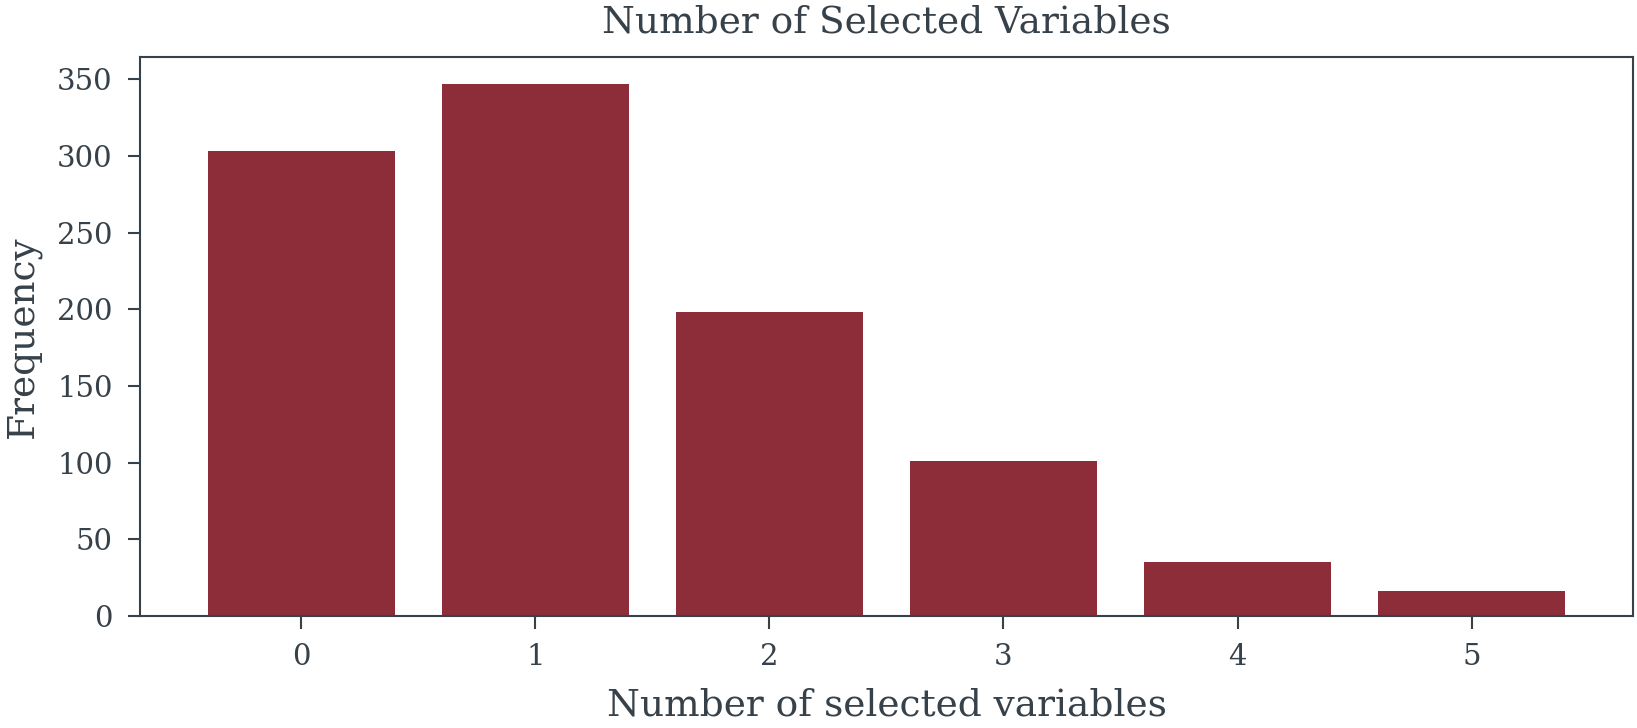

In [ ]:
#| echo: false
#| fig-cap: "Histogram of the number of selected variables in each trial using backward selection. The number of variables that are actually predictive are 0, however over 50% of the trials selected at least one variable as a statistically significant predictor."
#| label: fig-histogram-backward-selection
#plt.figure(figsize=(10, 5))
n_vars_selected = np.array([len(set(v)) for v in backward_selected_vars])
plt.hist(n_vars_selected, bins=np.unique(n_vars_selected), align='left', rwidth=0.8)
plt.xlabel("Number of selected variables")
plt.ylabel("Frequency")
plt.title("Number of Selected Variables");

In [ ]:
#| echo: false
print(f"Family-wise error rate: {np.mean(n_vars_selected > 0):.1%}")

Family-wise error rate: 69.7%


## Foward Selection

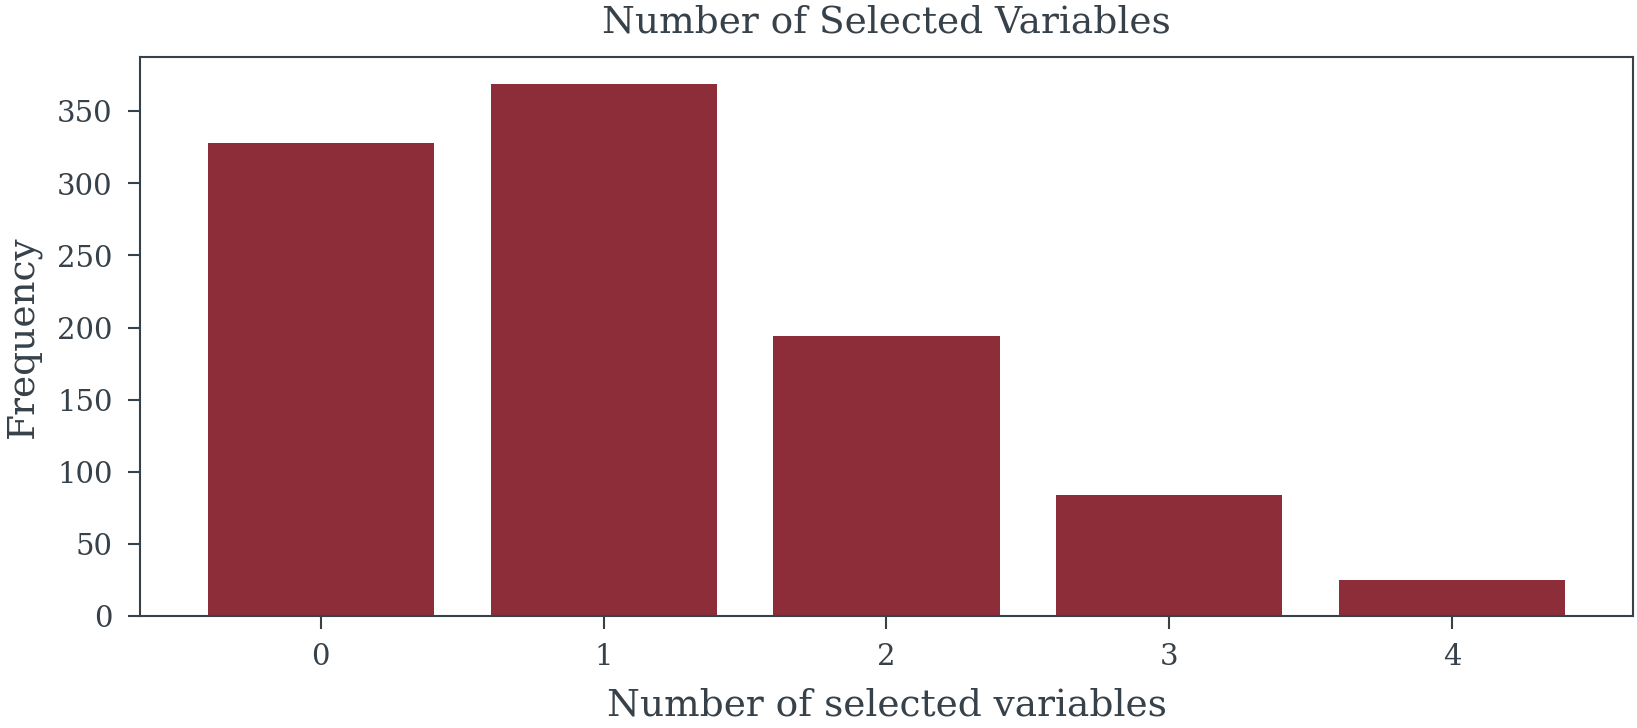

In [ ]:
#| echo: false
#| fig-cap: "Histogram of the number of selected variables in each trial using forward selection. The number of variables that are actually predictive are 0, however over 50% of the trials selected at least one variable as a statistically significant predictor."
#| label: fig-histogram-forward-selection
#plt.figure(figsize=(10, 5))
n_vars_selected = np.array([len(set(v)) for v in forward_selected_vars])
plt.hist(n_vars_selected, bins=np.unique(n_vars_selected), align='left', rwidth=0.8)
plt.xlabel("Number of selected variables")
plt.ylabel("Frequency")
plt.title("Number of Selected Variables");

In [ ]:
#| echo: false
print(f"Family-wise error rate: {np.mean(n_vars_selected > 0):.1%}")

Family-wise error rate: 67.2%


:::

**3. Chasing Ghosts in the Data**  
Selection procedures optimize for patterns specific to the training sample, capturing random fluctuations rather than stable relationships. This aggressive pursuit of in-sample fit produces models that fail catastrophically on new data.

::: {.panel-tabset}

## Backward Selection

::: {.callout-note collapse=true}
## Model Analysis

In [ ]:
SELECTION_METHOD = backward_selected_vars
n_models_with_var = {
    var: sum([var in selected for selected in SELECTION_METHOD])
    for var in X.columns
}
in_sample_models = [
    sm.OLS(
        y.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

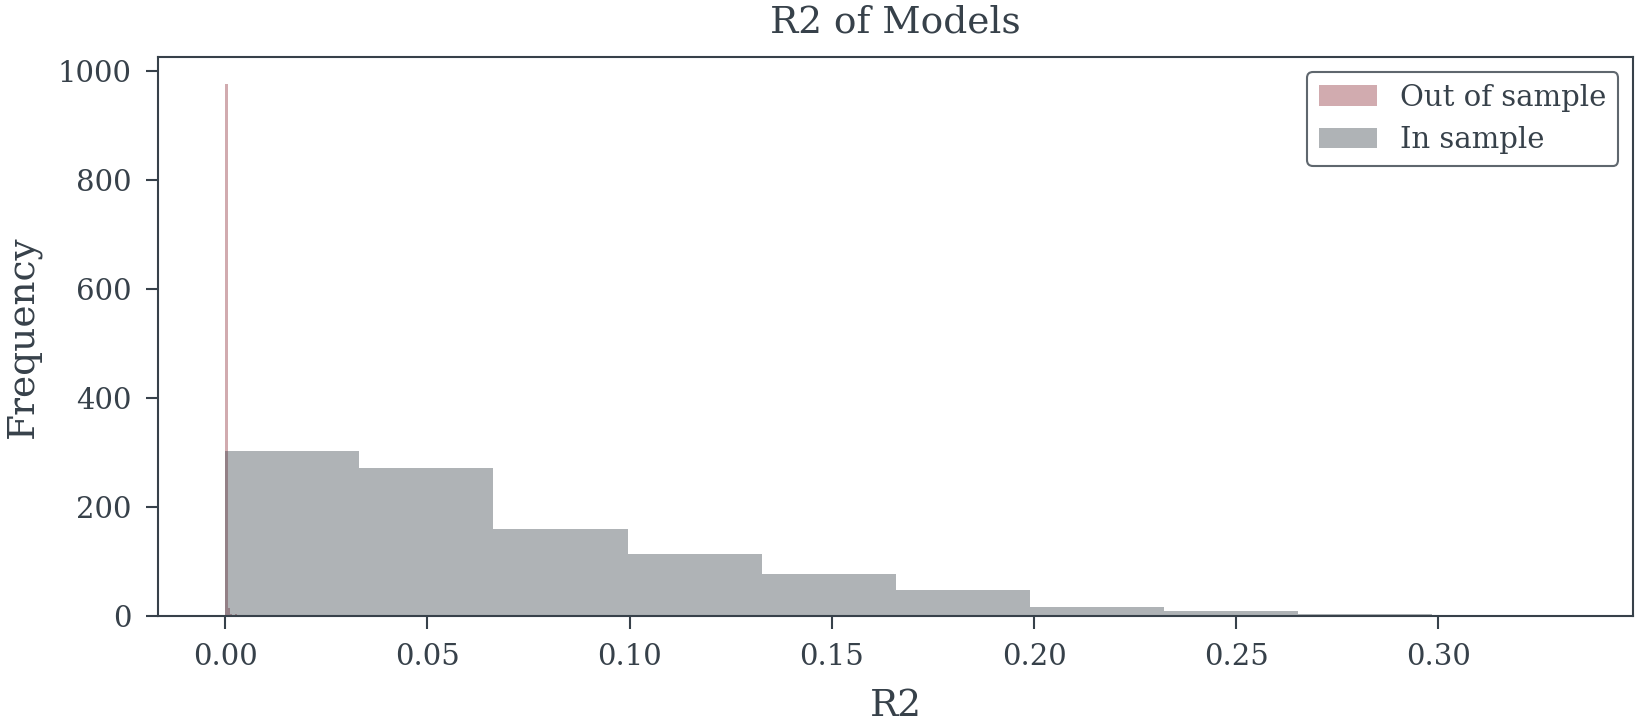

In [ ]:
#| echo: false
#| label: fig-histogram-backward-selection-r2
#| fig-cap: "In sample and out of sample R2 of the models selected using backward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
#plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample", color='C0')
plt.hist(in_sample_r2, alpha=.4, label="In sample", color='C1')
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

## Forward Selection

::: {.callout-note collapse=true}
## Model Analysis

In [ ]:
SELECTION_METHOD = forward_selected_vars
n_models_with_var = {
    var: sum([var in selected for selected in SELECTION_METHOD])
    for var in X.columns
}
in_sample_models = [
    sm.OLS(
        y.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

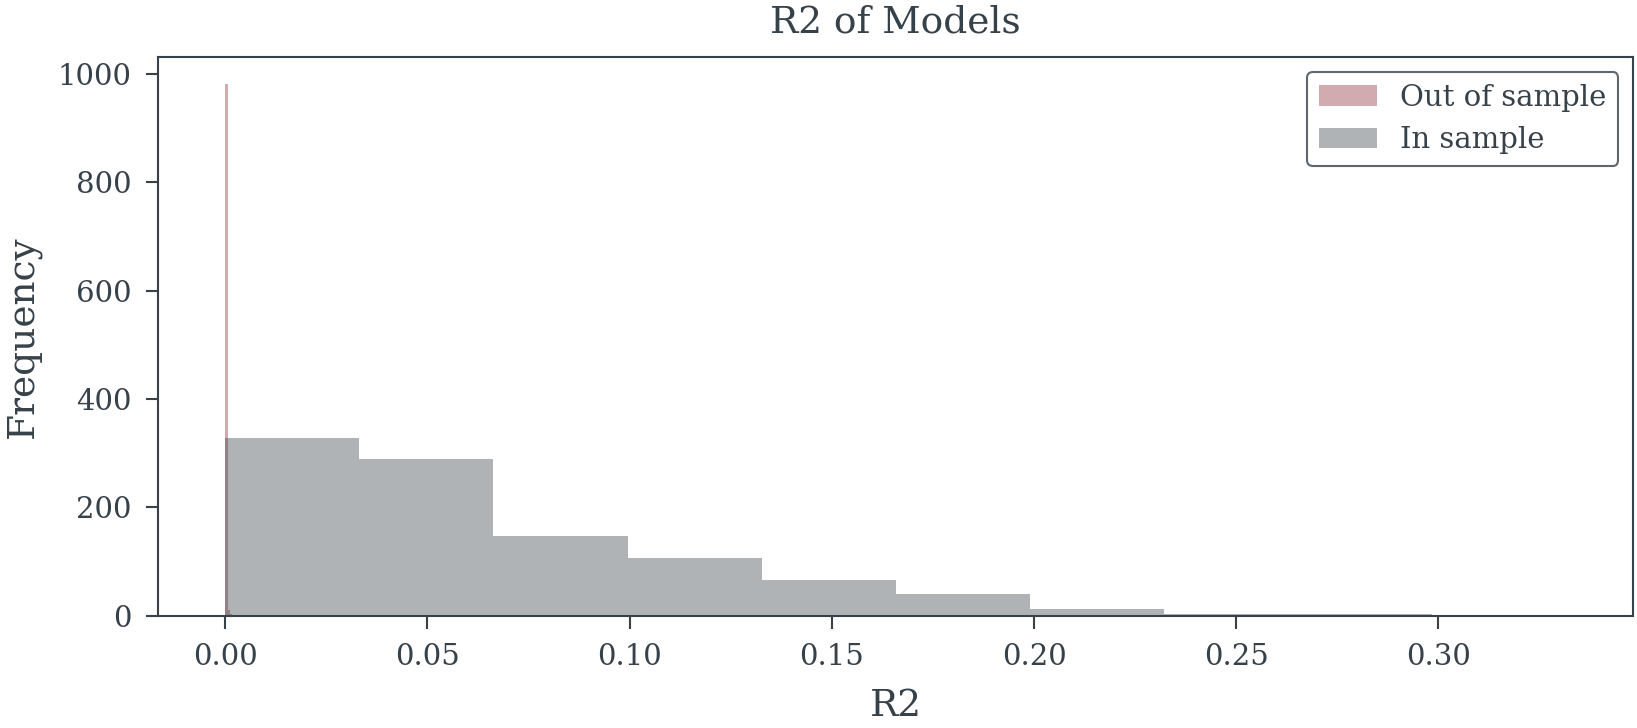

In [ ]:
#| echo: false
#| label: fig-histogram-forward-selection-r2
#| fig-cap: "In sample and out of sample R2 of the models selected using forward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
#plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample", color='C0')
plt.hist(in_sample_r2, alpha=.4, label="In sample", color="C1")
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

:::

::: {.callout-note collapse=true}
## Simulation with Signal

In [ ]:
betas = np.array([.2, .1, .3] + [0]*n_noise_vars)

X_signal, y_signal, betas = create_data_with_signal(
    n_trials*n_samples,
    n_signal_vars, 
    n_noise_vars, 
    correlated=True,
    betas=betas, 
    noise_level=3
)
X_signal.columns = [f"X{i}" for i in range(X_signal.shape[1])]
y_signal.name = "y"

In [ ]:
forward_selected_signal_vars = []
for trial in range(n_trials):
    trial_df = X_signal.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y_signal.loc[trial*n_samples:(trial+1)*n_samples-1]
    forward_selected_signal_vars.append(
        forward_selection(
            trial_df, 
            trial_y, 
            threshold_in=0.05
        )
    )

In [ ]:
backward_selected_signal_vars = []
for trial in range(n_trials):
    trial_df = X_signal.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y_signal.loc[trial*n_samples:(trial+1)*n_samples-1]
    backward_selected_signal_vars.append(
        backward_selection(
            trial_df, 
            trial_y, 
            threshold_out=0.05
        )
    )

:::

::: {.panel-tabset}

## Forward Selection

::: {.callout-note collapse=true}

## Model Analysis

In [ ]:
SELECTION_METHOD = forward_selected_signal_vars

in_sample_models = [
    sm.OLS(
        y_signal.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y_signal.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X_signal[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y_signal.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y_signal.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

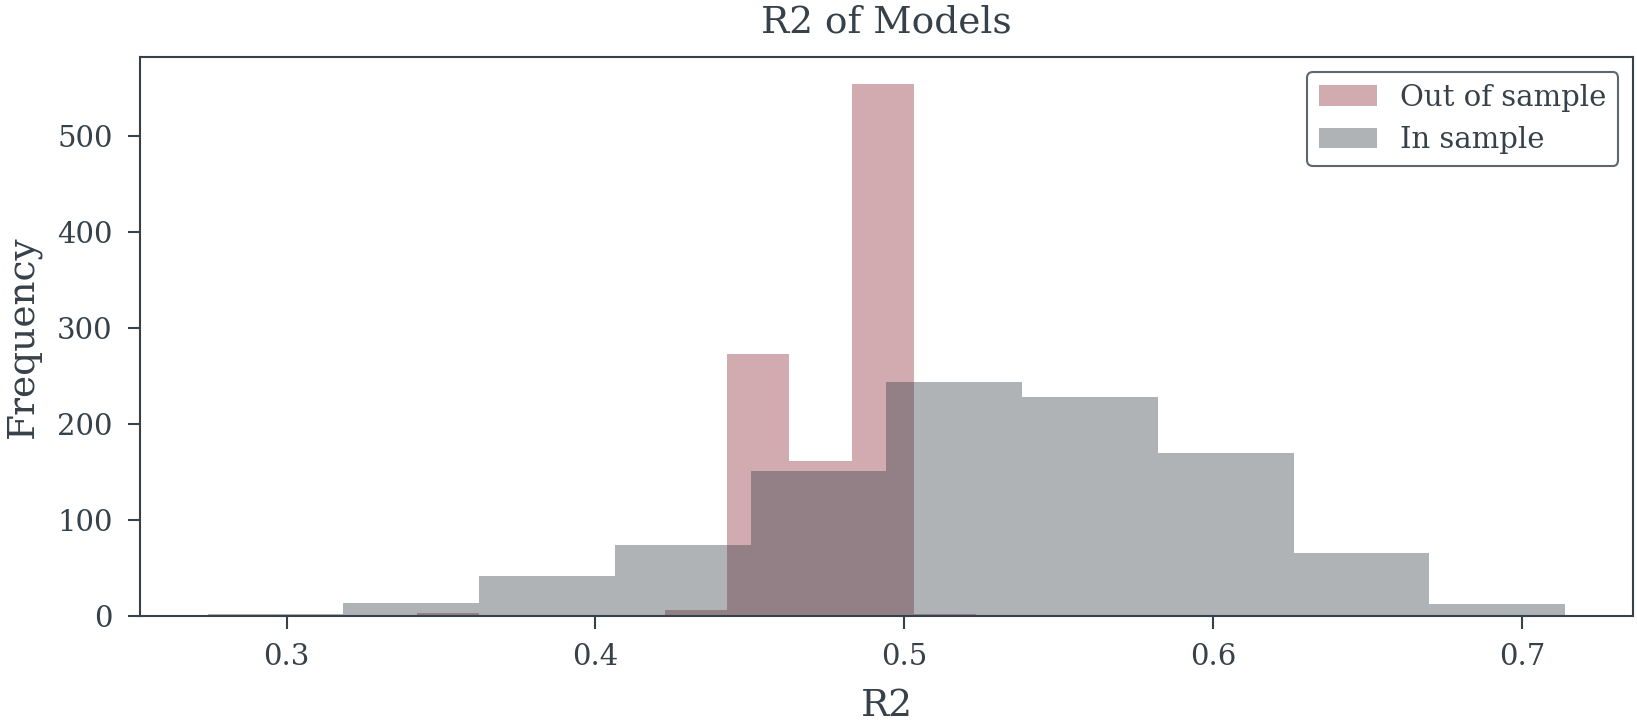

In [ ]:
#| echo: false
#| label: fig-histogram-forward-selection-r2-signal
#| fig-cap: "In sample and out of sample R2 of the models selected using forward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
#plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample", color='C0')
plt.hist(in_sample_r2, alpha=.4, label="In sample", color='C1')
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

## Backward Selection

::: {.callout-note collapse=true}

## Model Analysis

In [ ]:
SELECTION_METHOD = backward_selected_signal_vars

in_sample_models = [
    sm.OLS(
        y_signal.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y_signal.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X_signal[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y_signal.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y_signal.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

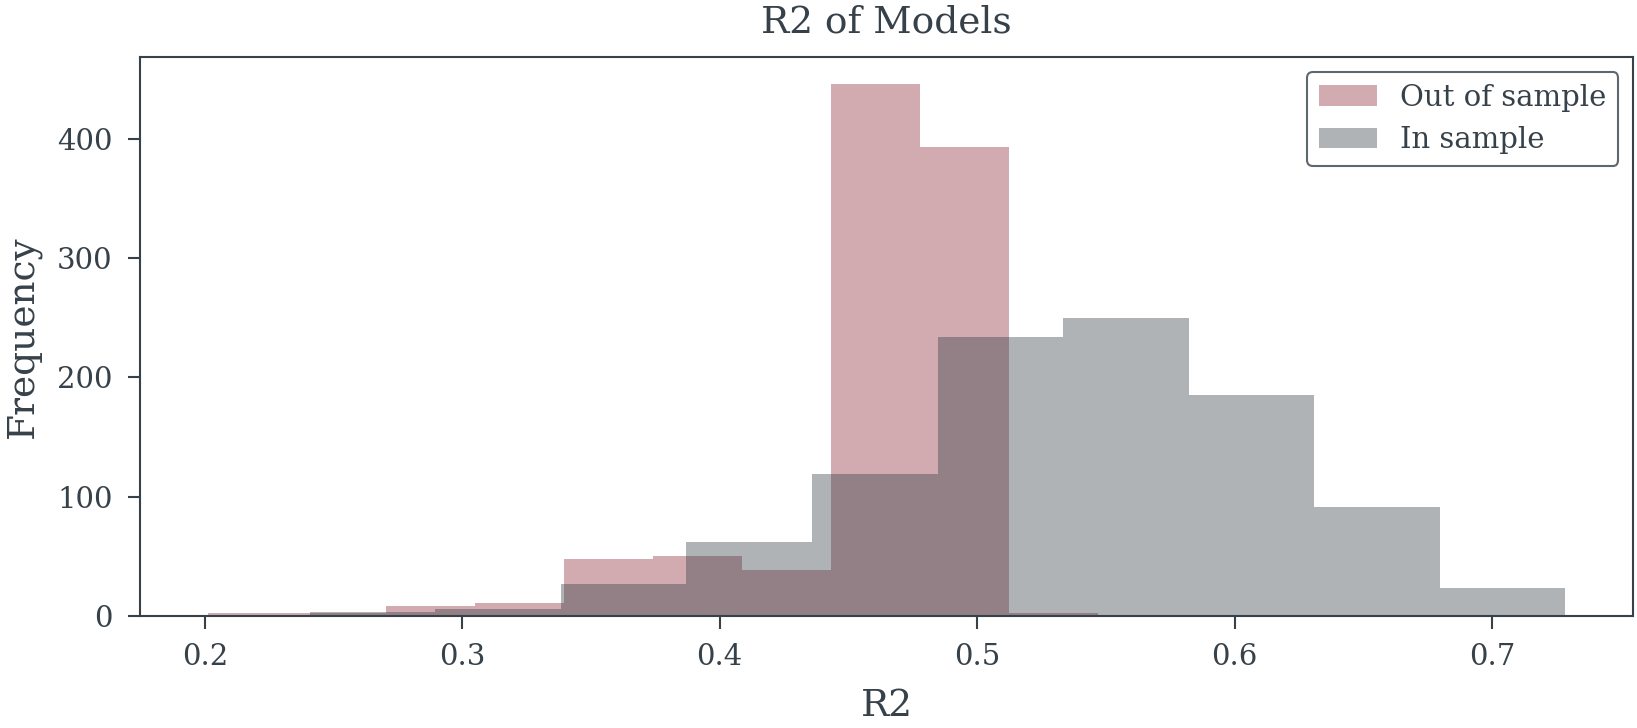

In [ ]:
#| echo: false
#| label: fig-histogram-backward-selection-r2-signal
#| fig-cap: "In sample and out of sample R2 of the models selected using backward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
#plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample", color='C0')
plt.hist(in_sample_r2, alpha=.4, label="In sample", color='C1')
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

:::

**4. Systematic Bias in Effect Sizes**  
Selected variables exhibit inflated coefficients—not because they're truly important, but because the selection process favors variables that randomly showed stronger associations. This "winner's curse" systematically overstates the magnitude of selected effects.

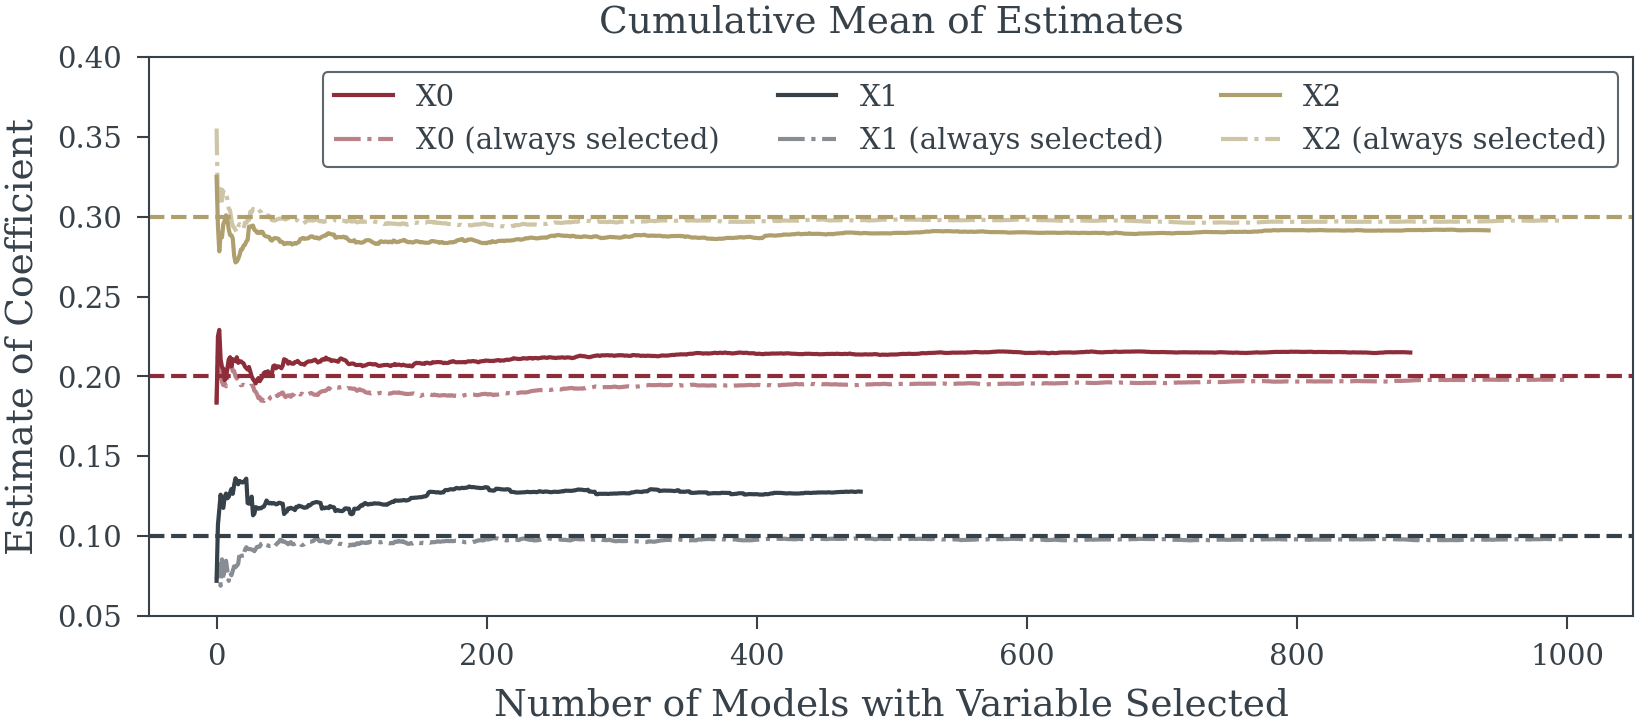

In [ ]:
#| echo: false
#| label: fig-bias-induced-by-selection
#| fig-cap: "The variable selection method systematically biases the coefficient estimates. This happens because models where the variable has a higher estimated effect are more likely to have that variable selected to be in the model. This is a form of selection bias."
in_sample_models_var_estimates = {f"X{i}": [model.params[f"X{i}"] for model in in_sample_models if f"X{i}" in model.params.index] for i in range(3)}
in_sample_models_var_cum_mean = {
    f"X{i}": np.cumsum(np.array(in_sample_models_var_estimates[f"X{i}"])) / np.arange(1, len(in_sample_models_var_estimates[f"X{i}"])+1)
    for i in range(3)
}

models_vars_always_selected = [sm.OLS(
    y_signal.loc[i*n_samples:(i+1)*n_samples-1], 
    sm.add_constant(X_signal.loc[i*n_samples:(i+1)*n_samples-1, ["X0", "X1", "X2"]+[var for var in np.random.choice(X_signal.columns[3:], 4, replace=False)]])
    ).fit() 
    for i in range(n_trials)
]

models_always_selected = {
    f'X{i}': [model.params[f'X{i}']
    for model in models_vars_always_selected]
    for i in range(3)
}
models_always_selected_cum_mean = {
    f'X{i}': np.cumsum(np.array(models_always_selected[f'X{i}'])) / np.arange(1, len(models_always_selected[f'X{i}'])+1)
    for i in range(3)
}
#plt.figure(figsize=(10, 5))
plt.title("Cumulative Mean of Estimates")
plt.ylabel("Estimate of Coefficient")
plt.xlabel("Number of Models with Variable Selected")
plt.plot(in_sample_models_var_cum_mean["X0"], label="X0", color='C0')
plt.plot(models_always_selected_cum_mean["X0"], label="X0 (always selected)", color='C0', alpha=.6, linestyle="-.")
plt.axhline(betas[0], linestyle="--", color='C0')
plt.plot(in_sample_models_var_cum_mean["X1"], label="X1", color='C1')
plt.plot(models_always_selected_cum_mean["X1"], label="X1 (always selected)", color='C1', alpha=.6, linestyle="-.")
plt.axhline(betas[1], color="C1", linestyle="--")
plt.plot(in_sample_models_var_cum_mean["X2"], label="X2", color='C2')
plt.plot(models_always_selected_cum_mean["X2"], label="X2 (always selected)", color='C2', alpha=.6, linestyle="-.")
plt.axhline(betas[2], color="C2", linestyle="--")
plt.legend(ncols=3)
plt.ylim(0.05, 0.4);

**5. False Precision**  
Post-selection standard errors understate true uncertainty. Confidence intervals appear misleadingly narrow, and p-values seem artificially compelling. These metrics assume the model was pre-specified, not constructed through data exploration, rendering them fundamentally invalid.

In [ ]:
#| hide
conf_int = {
    f"X{i}": [
        (
            (model.conf_int().loc[f'X{i}'][0]<betas[i]) 
            & (model.conf_int().loc[f'X{i}'][1]>betas[i]))
            for model in in_sample_models 
            if f'X{i}' in model.conf_int().index] 
            for i in range(3)
    }

In [ ]:
#| echo: false
print(f"Coverage of 95% confidence interval for X0: {np.mean(conf_int['X0']):.1%}")
print(f"Coverage of 95% confidence interval for X1: {np.mean(conf_int['X1']):.1%}")
print(f"Coverage of 95% confidence interval for X2: {np.mean(conf_int['X2']):.1%}")

Coverage of 95% confidence interval for X0: 85.3%
Coverage of 95% confidence interval for X1: 80.1%
Coverage of 95% confidence interval for X2: 83.1%


**6. Fragile Foundations**  
Minor data perturbations can dramatically alter selected variables, especially with correlated predictors common in marketing data. Models that shift drastically with small changes provide unreliable foundations for business decisions.

In [ ]:
#| echo: false
for key, freq in (pd.Series([tuple(sel) for sel in backward_selected_signal_vars]).value_counts().sort_values(ascending=False).head(10)/n_trials).items():
    print(f"Selection frequency of model Y ~ {" + ".join(key)}: {freq:.1%}")
print(f"Selection frequency of other models: {1-(pd.Series([tuple(sel) for sel in backward_selected_signal_vars]).value_counts().sort_values(ascending=False).head(10)/n_trials).sum():.1%}")

Selection frequency of model Y ~ X0 + X1 + X2: 17.8%
Selection frequency of model Y ~ X0 + X2: 12.2%
Selection frequency of model Y ~ X0 + X2 + X18: 1.4%
Selection frequency of model Y ~ X0 + X2 + X22: 1.1%
Selection frequency of model Y ~ X0 + X2 + X5: 1.1%
Selection frequency of model Y ~ X0 + X1 + X2 + X21: 0.9%
Selection frequency of model Y ~ X0 + X2 + X15: 0.9%
Selection frequency of model Y ~ X0 + X1 + X2 + X15: 0.8%
Selection frequency of model Y ~ X0 + X1 + X2 + X19: 0.8%
Selection frequency of model Y ~ X0 + X2 + X4: 0.7%
Selection frequency of other models: 62.3%


**7. Transformation Theater**  
Selecting functional forms (logarithmic, polynomial, adstock curves) based on significance compounds these problems. Testing hundreds of possible transformations virtually guarantees finding spurious patterns that optimize noise rather than signal.

**The fundamental flaw:** Using the same data for both model construction and inference violates core statistical principles. When data drives model specification, subsequent p-values and confidence intervals lose their theoretical justification. The model becomes a product of exploration, not a hypothesis to test.

### When Statistical Illusions Drive Business Decisions

The fundamental flaws in p-value driven selection cascade into real-world consequences that directly undermine business objectives. These aren't merely theoretical concerns—they systematically distort our understanding of marketing effectiveness and lead to predictably poor outcomes.

**False Signals Masquerading as Insights**

Time-series data creates fertile ground for statistical mirages. When ice cream sales and drowning incidents both spike in summer, naive selection procedures eagerly identify "significant" relationships without recognizing the underlying seasonal driver. In MMM contexts, these spurious associations proliferate: variables that merely share trends or seasonal patterns get misidentified as meaningful predictors. Each false inclusion not only clutters the model but actively degrades our ability to estimate genuine marketing effects with precision.

**The Hidden Cost of Arbitrary Thresholds**

Significance cutoffs create a binary world where p = 0.049 means inclusion and p = 0.051 means exclusion—despite these values being functionally identical. This arbitrary boundary systematically excludes genuine causal factors that happen to fall just above the threshold in a particular sample. When these excluded variables correlate with included predictors, their omission biases every remaining coefficient. The model doesn't just miss one relationship; it distorts all others.

**Causal Blindness in Automated Selection**

Statistical algorithms operate without causal awareness, unable to distinguish between fundamentally different types of relationships:
- **Confounders** that must be included to block spurious associations
- **Mediators** whose inclusion obscures the total effects we seek to measure  
- **Colliders** that create artificial associations when mistakenly conditioned upon

By selecting variables based solely on statistical association, these procedures routinely include variables that poison causal interpretation (mediators, colliders) while excluding those essential for valid inference (confounders). The resulting model becomes a causal minefield where coefficients represent unknown mixtures of direct effects, indirect pathways, and induced biases.

**The Analyst's Dilemma: When Wrong Becomes Right**

Perhaps most insidiously, these flawed models create organizational inertia that perpetuates their errors. Analysts face immense pressure to ensure their updated models produce the same high-level conclusions as previous efforts—that TV drives 30% of sales, that digital ROI is 2.5x, that seasonality accounts for 15% of variance. This leads to a troubling pattern of behaviors:

- **Reverse Engineering Results:** When new data suggests different attribution patterns, analysts manipulate model specifications until familiar conclusions emerge—adjusting adstock parameters, saturation curves, or control variables not for statistical validity but to reproduce expected ROI rankings
- **Strategic Time Splitting:** Models that attribute "too much" or "too little" to certain channels get subdivided into multiple time periods, fracturing the data until each segment yields the "correct" share of voice
- **Selective Variable Inclusion:** External factors get added or removed based on how they shift attribution between channels, using statistical significance as cover for what amounts to results manipulation
- **Transformation Shopping:** Analysts cycle through combinations of functional forms until the model produces ROI estimates and attribution percentages that align with organizational beliefs

This creates a vicious cycle where each generation of models must reproduce not just any results, but the specific business conclusions that stakeholders have internalized. "TV should drive 25-35% of sales" becomes an unquestionable truth that models must confirm rather than test.

**From Flawed Models to Failed Strategies**

These statistical distortions translate directly into business failures. Biased coefficients paint a fantasy landscape of marketing effectiveness—some channels appear artificially powerful while others seem worthless or even harmful. Budget optimization based on these illusions inevitably fails: money flows to channels whose effectiveness was overstated while truly profitable opportunities starve for investment. The false confidence provided by inappropriately narrow confidence intervals compounds the damage, encouraging aggressive reallocation based on estimates that are both wrong and wrongly certain.

**The Reproducibility Crisis in Practice**

Models built on sample-specific quirks fail to generalize. When next quarter's data arrives, the carefully selected variable set often produces wildly different results—or the selection procedure itself chooses entirely different variables. Rather than acknowledging this instability as evidence of flawed methodology, analysts scramble to manipulate the new model until it reproduces familiar attribution patterns and ROI hierarchies. This stability theater destroys organizational learning: teams spend more effort confirming past conclusions than discovering new truths. Strategic planning becomes impossible when the "insights" guiding it are actually fossilized artifacts of historical data mining.

**The compound effect is devastating:** flawed statistical procedures produce unstable models with biased coefficients, which generate incorrect ROI estimates that become organizational "truth," leading to poor budget allocation and ultimately reduced business performance. What begins as a methodological shortcut evolves into an institutional pathology where being consistently wrong becomes preferable to admitting uncertainty.


### The Reality Gap: When Exploratory Analysis Masquerades as Causal Insight

Modern Marketing Mix Modeling exists in a troubling state of methodological confusion. Practitioners routinely present their models as **predictive engines** capable of forecasting future performance, while stakeholders interpret and apply these same models as **causal instruments** for optimizing budget allocation. The uncomfortable truth is that most MMM implementations are, at best, **sophisticated exploratory analyses** dressed up in the language of prediction and causation.

This disconnect between claims and capabilities creates a cascade of poor decisions. When exploratory models—built through p-value mining and post-hoc selection—are treated as causal truth, organizations systematically misallocate resources based on statistical mirages. The biased coefficients and overfitted relationships that emerge from flawed selection procedures don't merely represent academic concerns; they translate directly into wasted marketing spend and missed opportunities.

**Perhaps most perniciously, these flawed models become the benchmarks against which new methodologies are evaluated.** When a novel approach produces different results from traditional stepwise regression, it's often dismissed as "inconsistent with established models" rather than recognized as potentially more accurate. This creates a self-reinforcing cycle where statistical illusions become institutionalized truths, and genuine improvements are rejected for failing to reproduce familiar biases.

The path forward requires honest acknowledgment of what current MMM practices actually deliver: exploratory insights that might suggest interesting patterns but cannot reliably predict future outcomes or identify causal relationships. Until the field adopts more rigorous methodologies—whether through Bayesian frameworks, proper regularization, or genuine causal inference techniques—we must stop pretending that models built on circular logic and data dredging can guide multi-million dollar decisions. **The stakes are too high, and the methods too flawed, to continue conflating exploration with explanation.**

## The Path Forward: Getting Comfortable with Uncertainty

### The Uncertainty Laundering Machine

Statistician Andrew Gelman offers a devastating critique of how statistics is abused that perfectly captures the MMM crisis:

> "The ethics comes in if we think of this entire journal publication system as a sort of machine for laundering uncertainty: researchers start with junk data (for example, poorly-thought-out experiments on college students, or surveys of online Mechanical Turk participants) and then work with the data, straining out the null results and reporting what is statistically significant, in a process analogous to the notorious mortgage lenders of the mid-2000s, who created high-value 'tranches' out of subprime loans. The loan crisis precipitated an economic recession, and I doubt the replication crisis will trigger such a crash in science. But I see a crucial similarity in that technical methods (structured finance for mortgages; statistical significance for scientific research) were being used to create value out of thin air."

This analogy illuminates exactly what's happening in MMM. We start with inherently uncertain, observational data—weekly sales figures confounded by countless factors, media spend that varies with business strategy, competitive actions we can't fully observe. Then we run this "junk data" through our statistical machinery, straining out the non-significant variables, p-hacking our way to impressive results, and packaging the survivors as "insights."

**Just as subprime mortgages got repackaged as AAA-rated securities, uncertain correlations get transformed into "proven" ROI figures.** The technical sophistication of the process—the complex adstock transformations, the multi-stage regression models, the impressive p-values—serves the same function as the financial engineering of the 2000s: it launders uncertainty, creating an appearance of value and reliability that doesn't actually exist.

### The MMM Value Mirage

In marketing analytics, this laundering process follows a predictable pattern:

1. **Start with messy reality:** Aggregated time series with ~200 observations, dozens of correlated variables, unobserved confounders
2. **Apply the machinery:** Stepwise regression, transformation selection, significance testing
3. **Strain out uncertainty:** Discard "non-significant" variables, ignore wide confidence intervals, suppress unstable results
4. **Package as certainty:** "TV delivers 3.2x ROI (p < 0.001)"

The organization receives what appears to be valuable intelligence—precise ROI estimates, clear attribution percentages, "data-driven" recommendations. But like those mortgage-backed securities, the value is illusory. We've used technical methods to create certainty out of thin air.

### From False Precision to Honest Ignorance

The marketing analytics industry has become addicted not just to certainty, but to this process of manufacturing it. Stakeholders demand precise ROI figures, and analysts have built an entire infrastructure—not to find truth, but to launder the fundamental uncertainty of marketing effectiveness into seemingly solid insights. The narrow confidence intervals and impressive p-values aren't evidence of precision; they're the output of a machine designed to hide uncertainty, not quantify it.

**The first step forward is dismantling the laundering machine.** We must stop using statistical sophistication to obscure uncertainty and start using it for its proper purpose: to honestly quantify and communicate what we don't know. Real marketing effects are messy, context-dependent, and riddled with uncertainty. Any methodology that claims otherwise is selling false comfort rather than actionable insight.


### Why Uncertainty Is Your Friend, Not Your Enemy

Uncertainty isn't a flaw to be hidden—it's crucial information that should guide decision-making. Consider two scenarios:

1. **Traditional approach:** "TV ROI is 3.2x"
2. **Honest approach:** "TV ROI is likely between 1.5x and 5x, with our best estimate at 3x"

The second statement contains more useful information. It acknowledges that TV might be marginally profitable or highly lucrative, suggesting a portfolio approach rather than an all-or-nothing strategy. The traditional approach's false precision encourages overconfident bets based on point estimates that are likely wrong.

**Uncertainty quantification enables better decisions:**
- **Portfolio thinking:** Wide credible intervals suggest diversification
- **Experimentation priorities:** High uncertainty indicates where tests would be most valuable
- **Risk management:** Understanding the range of possible outcomes prevents catastrophic misallocation
- **Stakeholder trust:** Acknowledging limitations builds more credibility than false precision

### Bayesian Methods: Where Uncertainty Is a Feature, Not a Bug

Bayesian approaches offer a natural framework for embracing uncertainty. Rather than producing single "best" models with spurious precision, Bayesian methods:

- **Quantify parameter uncertainty:** Every coefficient comes with a full probability distribution, not just a point estimate
- **Propagate uncertainty honestly:** Uncertainty in parameters flows through to uncertainty in predictions and decisions
- **Incorporate prior knowledge:** Historical information and business constraints enter through priors, not through p-hacking
- **Average over possibilities:** Instead of selecting one model, Bayesian Model Averaging acknowledges multiple plausible realities

When implemented properly, these methods produce results that might initially disappoint those seeking false precision: "Digital marketing ROI is probably positive (85% probability above 1.0x) with a median estimate of 1.8x and substantial uncertainty (90% credible interval: 0.7x to 4.2x)." Yet this honest assessment provides far more value than a precisely wrong point estimate.

### Practical Steps Toward Uncertainty-Aware MMM

**1. Reframe the Conversation**
- Stop asking "What's the exact ROI?" and start asking "What range of ROIs is plausible?"
- Replace "Which model is correct?" with "What do multiple reasonable models suggest?"
- Shift from "Prove this channel works" to "How confident are we about this channel's effectiveness?"

**2. Adopt Robust Methodologies**
- Implement regularization techniques that acknowledge coefficient uncertainty
- Use Bayesian methods with thoughtful priors based on accumulated knowledge
- Employ ensemble approaches that combine multiple models rather than selecting one
- Validate through hold-out testing that honestly assesses predictive uncertainty

**3. Visualize Uncertainty**
- Replace tables of point estimates with distributional plots
- Show credible/confidence intervals prominently, not as footnotes
- Use scenario planning based on uncertainty ranges
- Create decision rules that explicitly account for uncertainty levels

**4. Build Organizational Comfort**
- Educate stakeholders that uncertainty is information, not incompetence
- Celebrate decisions that acknowledge and plan for uncertainty
- Reward analysts who surface uncomfortable uncertainties over those who provide false comfort
- Create processes that use uncertainty to guide experimentation priorities

### The Competitive Advantage of Honest Uncertainty

Organizations that embrace uncertainty gain a paradoxical advantage: by admitting what they don't know, they make better decisions than competitors clinging to false precision. They:

- **Avoid catastrophic bets** based on spuriously precise estimates
- **Identify genuine opportunities** that uncertainty-averse competitors miss
- **Build resilient strategies** that perform well across plausible scenarios
- **Learn faster** by focusing experimentation where uncertainty is highest
- **Adapt more quickly** when reality diverges from estimates

### A New Standard for MMM Excellence

The future of marketing analytics lies not in ever-more-sophisticated methods for manufacturing certainty, but in frameworks that honestly quantify and communicate what we don't know. Excellence should be measured not by how narrow our confidence intervals are, but by how well our uncertainty estimates reflect reality.

This requires a fundamental shift: from viewing uncertainty as a problem to solve, to recognizing it as essential information for decision-making. Only by getting comfortable with uncertainty can we move beyond the statistical theater that currently dominates MMM and toward methods that genuinely improve marketing effectiveness.

**The path forward is clear:** Embrace uncertainty, quantify it honestly, and use it to make more robust decisions. The alternative—continuing to pretend we know more than we do—has already proven its capacity for expensive failure.

## From Statistical Theater to Decision Science: A Synthetic Case Study

### Introduction: Two Paradigms, Two Futures

To illustrate the stark contrast between current practices and what's possible, we present a synthetic case study of a hypothetical consumer brand allocating $50 million across marketing channels. We'll analyze the same dataset through two fundamentally different lenses:

**The Status Quo:** A traditional frequentist approach that relies on stepwise selection, p-value thresholds, and point estimates—the statistical laundering machine in action.

**The Alternative:** A Bayesian causal framework that explicitly models uncertainty, incorporates domain knowledge, and acknowledges multiple plausible realities—an honest attempt to support decision-making under uncertainty.

This isn't merely an academic exercise. The differences in these approaches translate directly into millions of dollars in marketing effectiveness. One path leads to overconfident bets based on statistical mirages; the other to robust strategies that perform well across the range of plausible truths. The following analysis demonstrates not just why change is necessary, but what that change looks like in practice.


#### 1. The Business Context and Data Generating Process
- Company background and marketing challenge
- True underlying causal structure (hidden from analysts)
- Simulated data generation with realistic confounders
- Observable variables vs. latent factors

#### 2. Approach A: The Frequentist P-Value Theater
- **2.1 The Analyst's Ritual**
  - Variable selection via stepwise regression
  - Transformation shopping for media curves
  - Chasing significance across model specifications
- **2.2 The Illusion of Precision**
  - Final model results and "significant" findings
  - Narrow confidence intervals and impressive p-values
  - ROI rankings and attribution claims
- **2.3 The Recommended Strategy**
  - Budget reallocation based on point estimates
  - Projected lift and business case

#### 3. Approach B: Bayesian Causal Reasoning
- **3.1 Mapping the Causal Landscape**
  - Eliciting stakeholder beliefs and concerns
  - Constructing multiple plausible DAGs
  - Identifying testable implications
- **3.2 Principled Variable Selection**
  - Spike-and-slab priors for uncertain relationships
  - Posterior inclusion probabilities vs. p-values
  - Handling confounders, mediators, and colliders
- **3.3 Embracing Model Uncertainty**
  - Bayesian Model Averaging across DAGs
  - Posterior distributions of causal effects
  - Sensitivity analysis to untestable assumptions

#### 4. From Uncertainty to Decisions
- **4.1 Decision Theory Meets Marketing**
  - Utility functions and business objectives
  - Expected value vs. robust optimization
  - Portfolio theory for marketing mix
- **4.2 The Uncertainty-Aware Strategy**
  - Allocation recommendations with credible intervals
  - Hedging across model uncertainty
  - Value of information analysis

#### 5. The Moment of Truth: Comparing Outcomes
- **5.1 Revealed Reality**
  - The true data generating process exposed
  - How each approach performed against truth
- **5.2 Financial Impact**
  - ROI achieved by each strategy
  - Cost of false certainty quantified
- **5.3 Robustness Analysis**
  - Performance across alternative scenarios
  - When each approach fails catastrophically

#### 6. Lessons for Practice
- **6.1 Why the Frequentist Approach Failed**
  - Specific mechanisms of failure
  - Warning signs that were ignored
- **6.2 Why the Bayesian Approach (Mostly) Succeeded**
  - How uncertainty quantification prevented disasters
  - Where even good methods struggle
- **6.3 Implementation Roadmap**
  - Practical steps for organizations
  - Common obstacles and solutions
  - Building institutional knowledge

#### 7. Beyond the Case Study: Implications for MMM
- The scalability question
- Computational and expertise requirements
- The organizational change challenge
- A new standard for marketing analytics



## Consequences of Flawed Selection in MMM
Employing naive selection methods and subsequent inference leads to significant practical problems:

- **Misattribution of ROI & Effects:** Biased estimates for marketing coefficients (ROI) and potentially inaccurate representations of media dynamics (adstock, saturation).

- **Flawed Budget Allocation:** Suboptimal marketing investment decisions stemming from unreliable ROI figures.

- **Poor Understanding of Business Drivers:** Incorrect identification of baseline factors (trends, seasonality, macroeconomics) and media response patterns.

- **Model Instability & Non-Reproducibility:** Selected factors and transformations may vary considerably with data updates, reducing model credibility.

- **Overfitting:** Models capture noise specific to the historical data, resulting in poor predictive performance for forecasting or simulations.

- **Misinterpretation of Control Factor Coefficients:** Attributing causal effects to the coefficients of baseline or control factors (e.g., macroeconomic variables, competitor activity) included in the model. These factors are typically observational and likely confounded themselves; their coefficients primarily reflect statistical association and adjustment needed to isolate media effects, not necessarily isolated causal impacts. This misinterpretation is related to the "Table 2 fallacy," where coefficients from a multivariable model are improperly treated as independent causal effects.

## Recommended Approaches and Considerations
Addressing these challenges requires more robust methodologies:

- **Rigorous Time-Series Handling:** Explicitly model or remove seasonality (e.g., dummies, Fourier terms, decomposition); test for and address non-stationarity (e.g., differencing); incorporate theoretically sound lags for media (adstock) and potentially external variables.

- **Regularization Methods (LASSO, Ridge, Elastic Net):** Handle many predictors simultaneously, perform coefficient shrinkage and implicit variable selection, often yielding more stable results than stepwise methods. Must be applied in conjunction with appropriate time-series structures.

- **Information Criteria (AIC, BIC):** Use for comparing non-nested models that correctly account for time-series properties, providing a more principled approach than p-value thresholds alone.

- **Time-Series Cross-Validation:** Employ methods like rolling-origin validation to assess out-of-sample predictive performance robustly.

- **Bayesian Frameworks:** Offer a probabilistic approach to uncertainty.

    - *Priors on Functional Forms:* Incorporate prior knowledge or average over plausible media transformations (adstock/saturation) instead of hard selection.

    - *Sparsity-Inducing Priors (e.g., Regularized Horseshoe):* Provide principled variable selection for external factors by shrinking irrelevant coefficients while retaining influential ones, directly modeling inclusion uncertainty.

- **Causal Inference Techniques:** Explore advanced time-series methods if the primary goal is establishing causal links (use with caution).

- **Domain Knowledge & Theory:** Prioritize pre-selecting candidate factors and transformation ranges based on business logic, economic theory, and prior research. Validate final model components for plausibility and stability.

::: {.callout-important}
## Improper Use of Domain Knowledge
Exogenous factors in MMM are frequently confounded with media variables or other unobserved drivers. Consequently, the estimated coefficient for an exogenous variable may not represent its direct causal impact on the outcome but rather the statistical adjustment necessary to deconfound the estimated media effects. Rejecting such a variable because its coefficient sign contradicts simple causal expectations might inadvertently remove a necessary control variable, potentially leading to more biased estimates of media effectiveness.
:::
Adopting these more rigorous approaches is fundamental to developing media mix models that are statistically sound, reliable, and strategically valuable.